## Logit Model with NUTS (same with HMC)

The details are from [here](https://cran.r-project.org/web/packages/hmclearn/vignettes/logistic_regression_hmclearn.html). 

The log posterior for logistic regression is given by the sum of the log likelihood and the log prior:

$$
\log p(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X}) = \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) + \log p(\boldsymbol{\beta})
$$

The log likelihood for logistic regression is given by:

$$
\log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i \log \left( \frac{1}{1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta})} \right) + (1 - y_i) \log \left( 1 - \frac{1}{1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta})} \right) \right]
$$

The log prior for a Gaussian distribution is given by:

$$
\log p(\boldsymbol{\beta}) = -\frac{1}{2} \boldsymbol{\beta}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\beta} + \text{const}
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of the Gaussian prior.

The gradient of the log posterior with respect to $\boldsymbol{\beta}$ is given by the sum of the gradient of the log likelihood and the gradient of the log prior:

$$
\nabla \log p(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X}) = \nabla \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) + \nabla \log p(\boldsymbol{\beta})
$$

The gradient of the log likelihood with respect to $\boldsymbol{\beta}$ is given by:

$$
\nabla \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) = \mathbf{X}^T (\mathbf{y} - \mathbf{p})
$$

where $\mathbf{p} = (p_1, ..., p_n)^T$ and $p_i = 1 / (1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta}))$.

The gradient of the log prior with respect to $\boldsymbol{\beta}$ is given by:

$$
\nabla \log p(\boldsymbol{\beta}) = -\boldsymbol{\Sigma}^{-1} \boldsymbol{\beta}
$$

In [1]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_likelihood(X, y, beta):
    z = X @ beta
    return y @ z - np.log(1 + np.exp(z)).sum()

def grad_log_likelihood(X, y, beta):
    z = X @ beta
    return X.T @ (y - sigmoid(z))

def leapfrog(X, y, beta, p, epsilon):
    p_half_step = p + epsilon / 2 * grad_log_likelihood(X, y, beta)
    beta_new = beta + epsilon * p_half_step
    p_new = p_half_step + epsilon / 2 * grad_log_likelihood(X, y, beta_new)
    return beta_new, p_new

In [9]:
import numpy as np

def build_tree(X, y, u, v, j, epsilon, beta, p, r, Emax=1000):
    if j == 0:
        # Base case, take one leapfrog step in the direction v
        beta_prime, p_prime = leapfrog(X, y, beta, p, v*epsilon)
        if u <= np.exp(log_likelihood(X, y, beta_prime) - 0.5*np.dot(p_prime, p_prime)):
            n_prime = 1
        else:
            n_prime = 0
        s_prime = int(log_likelihood(X, y, beta_prime) - 0.5*np.dot(p_prime, p_prime) > u - Emax)
        return beta_prime, p_prime, beta_prime, p_prime, beta_prime, n_prime, s_prime
    else:
        # Recursion, build left and right subtrees
        beta_minus, p_minus, beta_plus, p_plus, beta_prime, n_prime, s_prime = build_tree(X, y, u, v, j-1, epsilon, beta, p, r)
        if s_prime == 1:
            if v == -1:
                beta_minus, p_minus, _, _, beta_double_prime, n_double_prime, s_double_prime = build_tree(X, y, u, v, j-1, epsilon, beta_minus, p_minus, r)
            else:
                _, _, beta_plus, p_plus, beta_double_prime, n_double_prime, s_double_prime = build_tree(X, y, u, v, j-1, epsilon, beta_plus, p_plus, r)
            if np.random.uniform() < n_double_prime / max(n_prime + n_double_prime, 1):
                beta_prime = beta_double_prime
            if np.dot(beta_plus-beta_minus, p_minus) >= 0 and np.dot(beta_plus-beta_minus, p_plus) >= 0:
                s_prime = s_double_prime
            else:
                s_prime = 0
            n_prime += n_double_prime
        return beta_minus, p_minus, beta_plus, p_plus, beta_prime, n_prime, s_prime

def NUTS(X, y, epsilon, L, current_beta):
    p = np.random.normal(size=current_beta.shape)
    u = np.random.uniform(low=0, high=np.exp(log_likelihood(X, y, current_beta) - 0.5*np.dot(p, p)))
    beta_minus = beta_plus = beta_prime = current_beta
    p_minus = p_plus = p
    j = 0
    n_prime = s_prime = 1
    r = 1e-10
    while s_prime == 1:
        v = np.random.choice([-1, 1])
        if v == -1:
            beta_minus, p_minus, _, _, beta_prime, n_prime, s_prime = build_tree(X, y, u, v, j, epsilon, beta_minus, p_minus, r)
        else:
            _, _, beta_plus, p_plus, beta_prime, n_prime, s_prime = build_tree(X, y, u, v, j, epsilon, beta_plus, p_plus, r)
        r += n_prime
        if s_prime == 1 and np.random.uniform() < min(1, n_prime / r):
            current_beta = beta_prime
        j += 1
    return current_beta

In [10]:
# Test the HMC function
np.random.seed(0)
X = np.random.normal(size=(100, 2))
X = np.hstack([np.ones((100, 1)), X])  # add intercept
true_beta = np.array([0, 1, 2])
y = np.random.binomial(1, sigmoid(X @ true_beta))
epsilon = 0.1
L = 10
samples = []
current_beta = np.zeros(3)
for _ in range(1000):
    current_beta = NUTS(X, y, epsilon, L, current_beta)
    samples.append(current_beta)

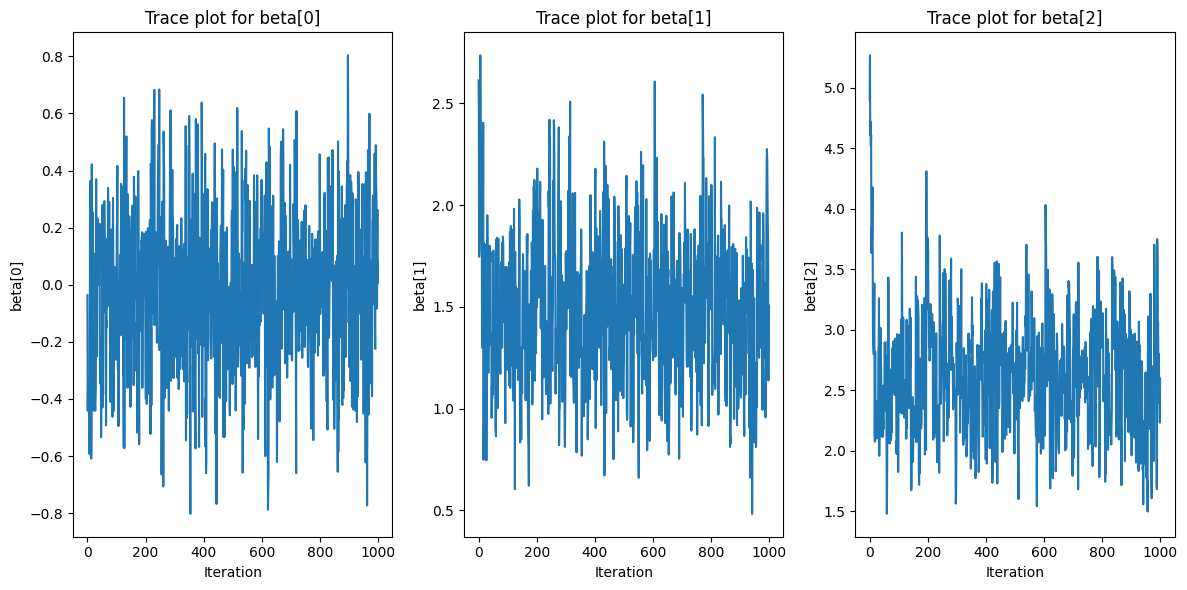

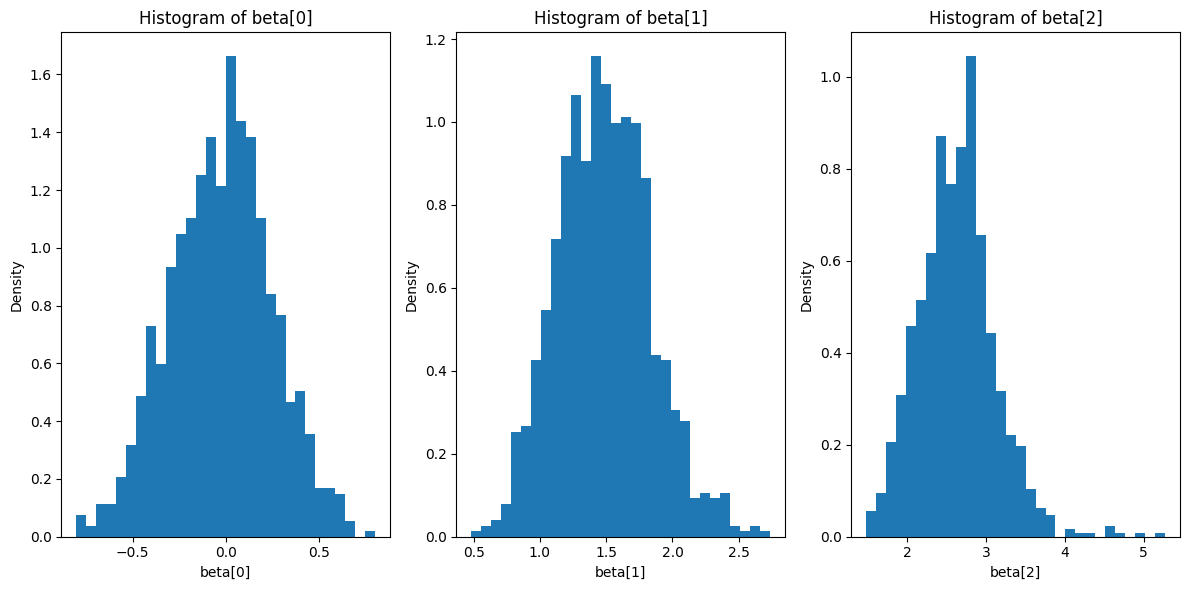

In [12]:
import matplotlib.pyplot as plt

samples = np.stack(samples)
# Plot the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(samples[:, 0])
plt.xlabel('Iteration')
plt.ylabel('beta[0]')
plt.title('Trace plot for beta[0]')

plt.subplot(1, 3, 2)
plt.plot(samples[:, 1])
plt.xlabel('Iteration')
plt.ylabel('beta[1]')
plt.title('Trace plot for beta[1]')

plt.subplot(1, 3, 3)
plt.plot(samples[:, 2])
plt.xlabel('Iteration')
plt.ylabel('beta[2]')
plt.title('Trace plot for beta[2]')


plt.tight_layout()
plt.show()

# Plot the histogram of the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(samples[:, 0], bins=30, density=True)
plt.xlabel('beta[0]')
plt.ylabel('Density')
plt.title('Histogram of beta[0]')

plt.subplot(1, 3, 2)
plt.hist(samples[:, 1], bins=30, density=True)
plt.xlabel('beta[1]')
plt.ylabel('Density')
plt.title('Histogram of beta[1]')

plt.subplot(1, 3, 3)
plt.hist(samples[:, 2], bins=30, density=True)
plt.xlabel('beta[2]')
plt.ylabel('Density')
plt.title('Histogram of beta[2]')

plt.tight_layout()
plt.show()